In [1]:
import numpy as np
import libaarhusxyz
def read_em_data_from_dat_xyz(em_data, name_gate_times='gate times', dat_type='dat'):
    gate_times = np.array(em_data.info[name_gate_times])
    df_em = em_data.flightlines
    group_em = df_em.groupby('record')
    records = list(group_em.groups.keys())
    df_em_collar = group_em[['line_no','utmx','utmy','timestamp','elevation','alt','tilt']].mean()

    dat_names = ['data_{:d}'.format(ii+1) for ii in range(gate_times.size)]
    df_em[dat_names] = em_data.layer_data['data']
    if dat_type == 'dat':    
        dat_std_names = ['datastd_{:d}'.format(ii+1) for ii in range(gate_times.size)]
        df_em[dat_std_names] = em_data.layer_data['datastd']    

    em_data_nan = em_data.layer_data['data']
    em_data_nan = em_data_nan.replace(9999, np.nan)
    n_ch1_active = np.round((~np.isnan(em_data_nan.loc[df_em[df_em.segment==1].index]).values).sum(axis=1).mean())
    n_ch2_active = np.round((~np.isnan(em_data_nan.loc[df_em[df_em.segment==2].index]).values).sum(axis=1).mean())
    print (f"Active # of channels: Ch1={n_ch1_active:.0f}, Ch2={n_ch2_active:.0f}")

    inds_lm = (~np.isnan(em_data_nan.loc[df_em[df_em.segment==1].index]).values).sum(axis=0) > 0.
    inds_hm = (~np.isnan(em_data_nan.loc[df_em[df_em.segment==2].index]).values).sum(axis=0) > 0.

    data_lm = []
    data_hm = []
    if dat_type == 'dat':
        datastd_lm = []
        datastd_hm = []
    records_inv = []
    for i_record in records:
        df_tmp = group_em.get_group(i_record)
        values = df_tmp[dat_names].values
        if dat_type == 'dat':
            values_std = df_tmp[dat_std_names].values
        if df_tmp.shape[0] == 2:
            i_lm = np.argwhere(df_tmp['segment'].values==1)[0][0]                
            i_hm = np.argwhere(df_tmp['segment'].values==2)[0][0]
            data_lm.append(values[i_lm,inds_lm])
            data_hm.append(values[i_hm,inds_hm])
            if dat_type == 'dat':
                datastd_lm.append(values_std[i_lm,inds_lm])
                datastd_hm.append(values_std[i_hm,inds_hm])        
            records_inv.append(i_record)
    data_lm = np.vstack(data_lm)
    data_hm = np.vstack(data_hm)
    if dat_type == 'dat':
        datastd_lm = np.vstack(datastd_lm)
        datastd_hm = np.vstack(datastd_hm)
    records_inv = np.hstack(records_inv)
    df_em_inv = df_em_collar.loc[records_inv]
    times_lm_inv = gate_times[inds_lm]
    times_hm_inv = gate_times[inds_hm]    

    ch1_names = ['dbdt_ch1gt_{:d}'.format(ii+1) for ii in range(data_lm.shape[1])]
    ch2_names = ['dbdt_ch2gt_{:d}'.format(ii+1) for ii in range(data_hm.shape[1])]
    if dat_type == 'dat':    
        std_ch1_names = ['dbdt_std_ch1gt_{:d}'.format(ii+1) for ii in range(data_lm.shape[1])]
        std_ch2_names = ['dbdt_std_ch2gt_{:d}'.format(ii+1) for ii in range(data_hm.shape[1])]    

    df_em_inv[ch1_names] = data_lm
    df_em_inv[ch2_names] = data_hm
    if dat_type == 'dat':    
        df_em_inv[std_ch1_names] = datastd_lm
        df_em_inv[std_ch2_names] = datastd_hm
    
    meta_data_dict = {}
    meta_data_dict['ch1_names'] = ch1_names
    meta_data_dict['ch2_names'] = ch2_names
    if dat_type == 'dat':    
        meta_data_dict['std_ch1_names'] = std_ch1_names
        meta_data_dict['std_ch2_names'] = std_ch1_names
    meta_data_dict['ch1_times'] = times_lm_inv
    meta_data_dict['ch2_times'] = times_hm_inv
    df_em_inv = df_em_inv.replace(9999, np.nan)
    return df_em_inv, meta_data_dict

In [2]:
import pandas as pd
import dill

In [3]:
work_dir = "/Users/sgkang09/Dropbox/Stanford/Seogi-Jonny/targeted_inversion/em_data_cv/sa_4_2022_spring/"
fname = work_dir+"WO4_SCIsmooth_MOD_dat.xyz"
aem_data = libaarhusxyz.XYZ(fname)
fname = work_dir+"WO4_SCIsmooth_MOD_syn.xyz"
aem_data_syn = libaarhusxyz.XYZ(fname)

In [4]:
fname = work_dir+"WO4_SCIsmooth_MOD_inv.xyz"
aem_model = libaarhusxyz.XYZ(fname)

In [5]:
# df_em_inv, meta_data_dict = read_em_data_from_dat_xyz(aem_data, name_gate_times='gate times (s)')
# dill.dump(meta_data_dict, open('sa_4_meta_data.pik', 'wb'))
# df_em_inv.to_parquet('sa_4_inv.parquet')
# df_em_syn, _ = read_em_data_from_dat_xyz(aem_data_syn, name_gate_times='gate times (s)', dat_type='syn')
# df_em_syn.to_parquet('sa_4_syn.parquet')

In [6]:
df_em_inv = pd.read_parquet(work_dir+"sa_4_inv.parquet")
df_em_syn = pd.read_parquet(work_dir+"sa_4_syn.parquet")
meta_data_dict = dill.load(open(work_dir+"sa_4_meta_data.pik", "rb"))

In [7]:
xy = aem_data.flightlines[['utmx', 'utmy']].values

In [8]:
# fname = "/Users/sgkang09/Dropbox/Stanford/Seogi-Jonny/targeted_inversion/em_data_cv/sa_5_2022_spring/SCI_smooth30L_MOD_syn.xyz"
# aem_data_5 = libaarhusxyz.XYZ(fname)
# xy_5 = aem_data_5.flightlines[['utmx', 'utmy']].values

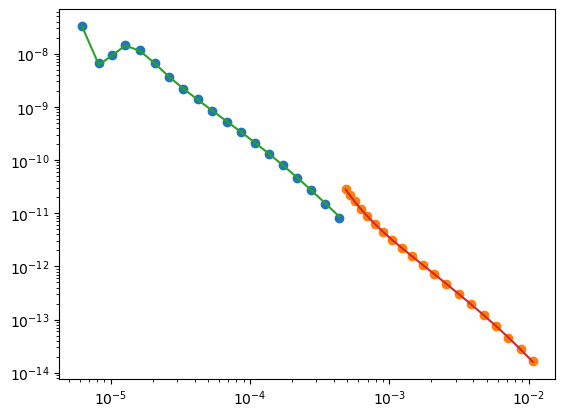

In [40]:
import matplotlib.pyplot as plt
ch1_names = meta_data_dict['ch1_names']
ch2_names = meta_data_dict['ch2_names']
times_ch1 = meta_data_dict['ch1_times'] -1.99e-6
times_ch2 = meta_data_dict['ch2_times']

record_tmp = 1000
plt.loglog(times_ch1, abs(df_em_inv.loc[record_tmp][ch1_names]), 'o')
plt.loglog(times_ch2, abs(df_em_inv.loc[record_tmp][ch2_names]), 'o')
plt.loglog(times_ch1, abs(df_em_syn.loc[record_tmp][ch1_names]), '-')
plt.loglog(times_ch2, abs(df_em_syn.loc[record_tmp][ch2_names]), '-')

In [41]:
df_rho_collar = aem_model.flightlines
rho = aem_model.layer_data['rho_i'].loc[df_rho_collar[df_rho_collar['record']==record_tmp].index].values.flatten()
thickness = aem_model.layer_data['thk'].loc[df_rho_collar[df_rho_collar['record']==record_tmp].index].values.flatten()

In [42]:
system = libaarhusxyz.parse_gex("/Users/sgkang09/Dropbox/Stanford/Seogi-Jonny/targeted_inversion/em_data_cv/sa_4_2022_spring/20220406_20039_WO4_Ramboll_312_30Hz_SR2.gex")
area = system['General']['TxLoopArea']
waveform_hm = system['General']['WaveformHMPoint']
waveform_lm = system['General']['WaveformLMPoint']
i_start_hm = int(system['Channel2']['RemoveInitialGates'])
i_start_lm = int(system['Channel1']['RemoveInitialGates'])
time_input_currents_hm = waveform_hm[:,0]
input_currents_hm = waveform_hm[:,1]
time_input_currents_lm = waveform_lm[:,0]
input_currents_lm = waveform_lm[:,1]

time_gates = system['General']['GateTime']
# GateTimeShift=system['Channel1']['GateTimeShift']
GateTimeShift = -1.99e-6
MeaTimeDelay=system['Channel1']['MeaTimeDelay']
NoGates=int(system['Channel1']['NoGates'])
print (GateTimeShift, MeaTimeDelay)
t0_lm = waveform_lm[:,0].max()
times_lm = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:]
GateTimeShift=system['Channel2']['GateTimeShift']
MeaTimeDelay=system['Channel2']['MeaTimeDelay']
NoGates=int(system['Channel2']['NoGates'])
t0_hm = waveform_hm[:,0].max()
times_hm = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:]

header [General] parsed
header [Channel1] parsed
header [Channel2] parsed
-1.99e-06 0.0


In [61]:
times_lm[4:4+19]

array([6.2250e-06, 8.2300e-06, 1.0220e-05, 1.2730e-05, 1.6220e-05,
       2.0720e-05, 2.6220e-05, 3.3230e-05, 4.2220e-05, 5.3720e-05,
       6.8220e-05, 8.6220e-05, 1.0871e-04, 1.3671e-04, 1.7221e-04,
       2.1771e-04, 2.7471e-04, 3.4671e-04, 4.3771e-04])

In [62]:
times_ch1

array([6.2250e-06, 8.2300e-06, 1.0220e-05, 1.2730e-05, 1.6220e-05,
       2.0720e-05, 2.6220e-05, 3.3230e-05, 4.2220e-05, 5.3720e-05,
       6.8220e-05, 8.6220e-05, 1.0871e-04, 1.3671e-04, 1.7221e-04,
       2.1771e-04, 2.7471e-04, 3.4671e-04, 4.3771e-04])

In [45]:
times_ch2

array([0.0004872, 0.0005227, 0.0005682, 0.0006252, 0.0006972, 0.0007882,
       0.0009022, 0.001046 , 0.001228 , 0.001456 , 0.001744 , 0.002109 ,
       0.002567 , 0.003145 , 0.003864 , 0.004744 , 0.005822 , 0.00714  ,
       0.008754 , 0.01073  ])

In [46]:
# source_height = df_em_inv.loc[record_tmp]['alt']
source_height = df_rho_collar[df_rho_collar['record']==record_tmp]['invalt'].values[0]

In [47]:
xy_tmp = df_rho_collar[df_rho_collar['record']==record_tmp][['utmx', 'utmy']].values

In [48]:
system['General']['RxCoilLPFilter']

array([9.900e-01, 2.044e+05])

In [49]:
system['Channel1']['TiBLowPassFilter']

array([1.e+00, 3.e+05])

In [50]:
system['Channel2']['TiBLowPassFilter']

array([1.e+00, 3.e+05])

In [51]:
from discretize import TensorMesh
import numpy as np
from simpeg import maps
import simpeg.electromagnetics.time_domain as tdem
from simpeg.electromagnetics.utils.em1d_utils import set_mesh_1d

# Source properties
source_location = np.array([0., 0., source_height])  
source_orientation = "z"                      # "x", "y" or "z"
source_current = 1.                           # maximum on-time current

# Receiver properties
receiver_location = np.array([13.25, 0., source_height+2.])
receiver_orientation = "z"                    # "x", "y" or "z"
# Receiver list
# Define receivers at each location.
receivers_lm_list = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times_ch1, "z",
        bw_cutoff_frequency=3e5,
        bw_power=1,
        lp_cutoff_frequency=2.044e+05,
        lp_power=0.99,        
    ),
]  # Make a list containing all receivers even if just one
receivers_hm_list = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times_ch2, "z",
        bw_cutoff_frequency=3e5,
        bw_power=1,
        lp_cutoff_frequency=2.044e+05,
        lp_power=0.99,        
    ),
]  # Make a list containing all receivers even if just one

waveform_lm = tdem.sources.PiecewiseLinearWaveform(
        times=time_input_currents_lm, currents=input_currents_lm
)
waveform_hm = tdem.sources.PiecewiseLinearWaveform(
        times=time_input_currents_hm, currents=input_currents_hm
)
# Must define the transmitter properties and associated receivers
source_list = [
    tdem.sources.MagDipole(
        receivers_lm_list,
        location=source_location,
        waveform=waveform_lm,
    ),
    tdem.sources.MagDipole(
        receivers_hm_list,
        location=source_location,
        waveform=waveform_hm,
    ),    
]

survey = tdem.Survey(source_list)
# Define the simulation
simulation = tdem.Simulation1DLayered(
    survey=survey, thicknesses=thickness, sigmaMap=maps.IdentityMap(nP=len(rho)),
)
# %%time
dpred = simulation.dpred(1./rho)  

In [52]:
dpred

array([ 2.57868164e-08,  8.43221246e-10, -1.18959831e-08, -1.24360341e-08,
       -1.13641643e-08, -6.25072705e-09, -3.60095366e-09, -2.16579863e-09,
       -1.33287098e-09, -8.31663153e-10, -5.23928878e-10, -3.31806133e-10,
       -2.08634842e-10, -1.29593502e-10, -7.85262476e-11, -4.61253376e-11,
       -2.66239490e-11, -1.50948916e-11, -8.46210183e-12, -2.75102758e-11,
       -2.12690761e-11, -1.60089656e-11, -1.18429335e-11, -8.62254409e-12,
       -6.20224059e-12, -4.43273960e-12, -3.14306496e-12, -2.20596126e-12,
       -1.53353796e-12, -1.04921026e-12, -7.03850195e-13, -4.64159404e-13,
       -3.00027617e-13, -1.91131736e-13, -1.20559606e-13, -7.49456840e-14,
       -4.57328753e-14, -2.72406168e-14, -1.57766285e-14])

In [53]:
len(ch1_names)

19

In [54]:
len(ch2_names)

20

In [55]:
dpred.shape

(39,)

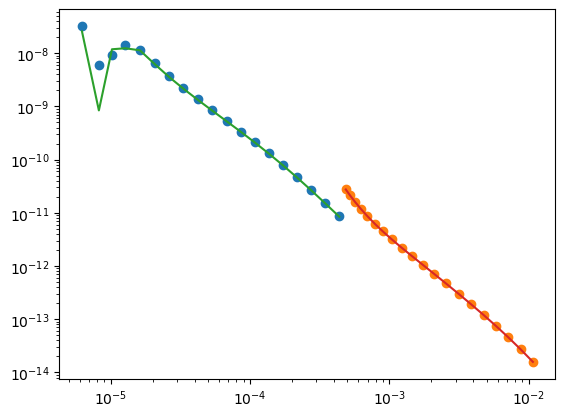

In [56]:
plt.loglog(times_ch1, abs(df_em_syn.loc[record_tmp][ch1_names]), 'o')
plt.loglog(times_ch2, abs(df_em_syn.loc[record_tmp][ch2_names]), 'o')
plt.loglog(times_ch1, abs(dpred[:len(ch1_names)]), '-')
plt.loglog(times_ch2, abs(dpred[len(ch1_names):]), '-')

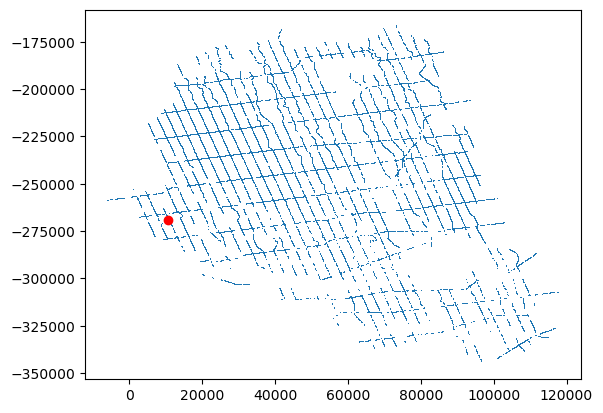

In [22]:
plt.plot(xy[:,0], xy[:,1], ',')
plt.plot(xy_tmp[:,0], xy_tmp[:,1], 'ro')
